# A11-Q2: Adversarial Attacks

In [1]:
# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset: MNIST

In [4]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [5]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [6]:
def draw(x):
    with torch.no_grad():
        plt.imshow(x.cpu().numpy().reshape((img_size,img_size)), cmap='gray');
        plt.axis('off');

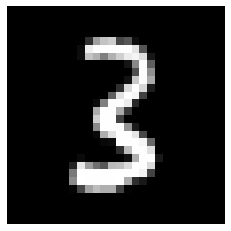

In [7]:
x,t = ds_full.__getitem__(50000)
draw(x)

In [8]:
ds = ds_full
#ds = torch.utils.data.Subset(ds_full, range(1024))

# Obtain trained network
You can train the network yourself. However, if you would rather skip that part, a pre-trained network is supplied. That is what will be run by default.

In [9]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)
     
     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).
     
     The output of the network is the log of the 10 class probabilities
     (ie. log-softmax). Correspondingly, this network uses the
     negative log-likelihood loss function (nn.NLLLoss).
    '''
    def __init__(self, img_size=28):
        super().__init__()
        self.lyrs = nn.Sequential(
            nn.Linear(img_size**2, 100), nn.ReLU(),
            nn.Linear(100, 10), nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)
        
        
    def forward(self, x):
        return self.lyrs(x)
    
    
    def learn(self, dl, optimizer=None, epochs=10):
        '''
         net.learn(dl, optimizer=None, epochs=10)
         
         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().
         
         The targets for the dataset are assumed to be class indices.
        '''
        if optimizer is None:
            print('Need to specify an optimizer and loss function')
            return
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                y = self(x)
                loss = self.loss_fcn(y, t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');

In [10]:
net = MyNet(img_size)

In [11]:
dl = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True)
# Uncomment the next line if you want to train it yourself.
#net.learn(dl, optimizer=torch.optim.Adam(net.parameters(), lr=0.001), epochs=10)

In [12]:
# Uncomment this line to save your network.
#torch.save(net.cpu(), 'mnist_trained.pt')

In [13]:
# Use the line below to load a pre-trained network from a file.
# Note that the MyNet class should be defined for this to work.
net = torch.load('mnist_trained.pt').to(device)

In [14]:
# If you'd like some confidence that the network is well trained, you can
# test its accuracy.
# The supplied network should have a test accuracy over 97%.

def accuracy(net, dl):
    total_correct = 0.
    for x,t in dl:
        y = net(x.to(device))
        blah = torch.argmax(y.cpu(), dim=1)
        total_correct += torch.sum(blah==t).cpu().item()
    return total_correct/len(dl.dataset)

dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256)
acc = accuracy(net, dl_test)
print(f'Accuracy = {acc*100.:0.2f}%')

Accuracy = 97.82%


# A. `fgsm` Method

In [15]:
def fgsm(net, x, t, eps=0.01, targ=False):
    '''
        x_adv = FGSM(net, x, t, eps=0.01, targ=False)
        
        Performs the Fast Gradient Sign Method, perturbing each input by
        eps (in infinity norm) in an attempt to have it misclassified.
        
        Inputs:
          net    PyTorch Module object
          x      DxI tensor of a batch of inputs
          t      tensor of D corresponding class indices
          eps    the maximum infinity-norm perturbation from the input
          targ   Boolean, indicating if the FGSM is targetted
                   - if targ is False, then t is considered to be the true
                     class of the input, and FGSM will work to increase the cost
                     for that target
                   - if targ is True, then t is considered to be the target
                     class for the perturbation, and FGSM will work to decrease the
                     cost of the output for that target class
        
        Output:
          x_adv  tensor of a batch of adversarial inputs, the same size as x
    '''

    # You probably want to create a copy of x so you can work with it.
    x_adv = x.clone().to(device)
    x_adv.requires_grad = True
    #===== YOUR CODE HERE =====
    # set the sign
    sign = 1
    if targ: # target attack needs sign to be -1
        sign = -1
    y = net(x_adv)
    loss = net.loss_fcn(y, t) # compute the loss
    net.zero_grad()
    loss.backward() # gradient obtained
    return x_adv + sign * eps * (torch.sign(x_adv.grad)) #fomula to compute

# B. Untargetted

In [16]:
dl_all = torch.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=False)
x,t = next(iter(dl_all))

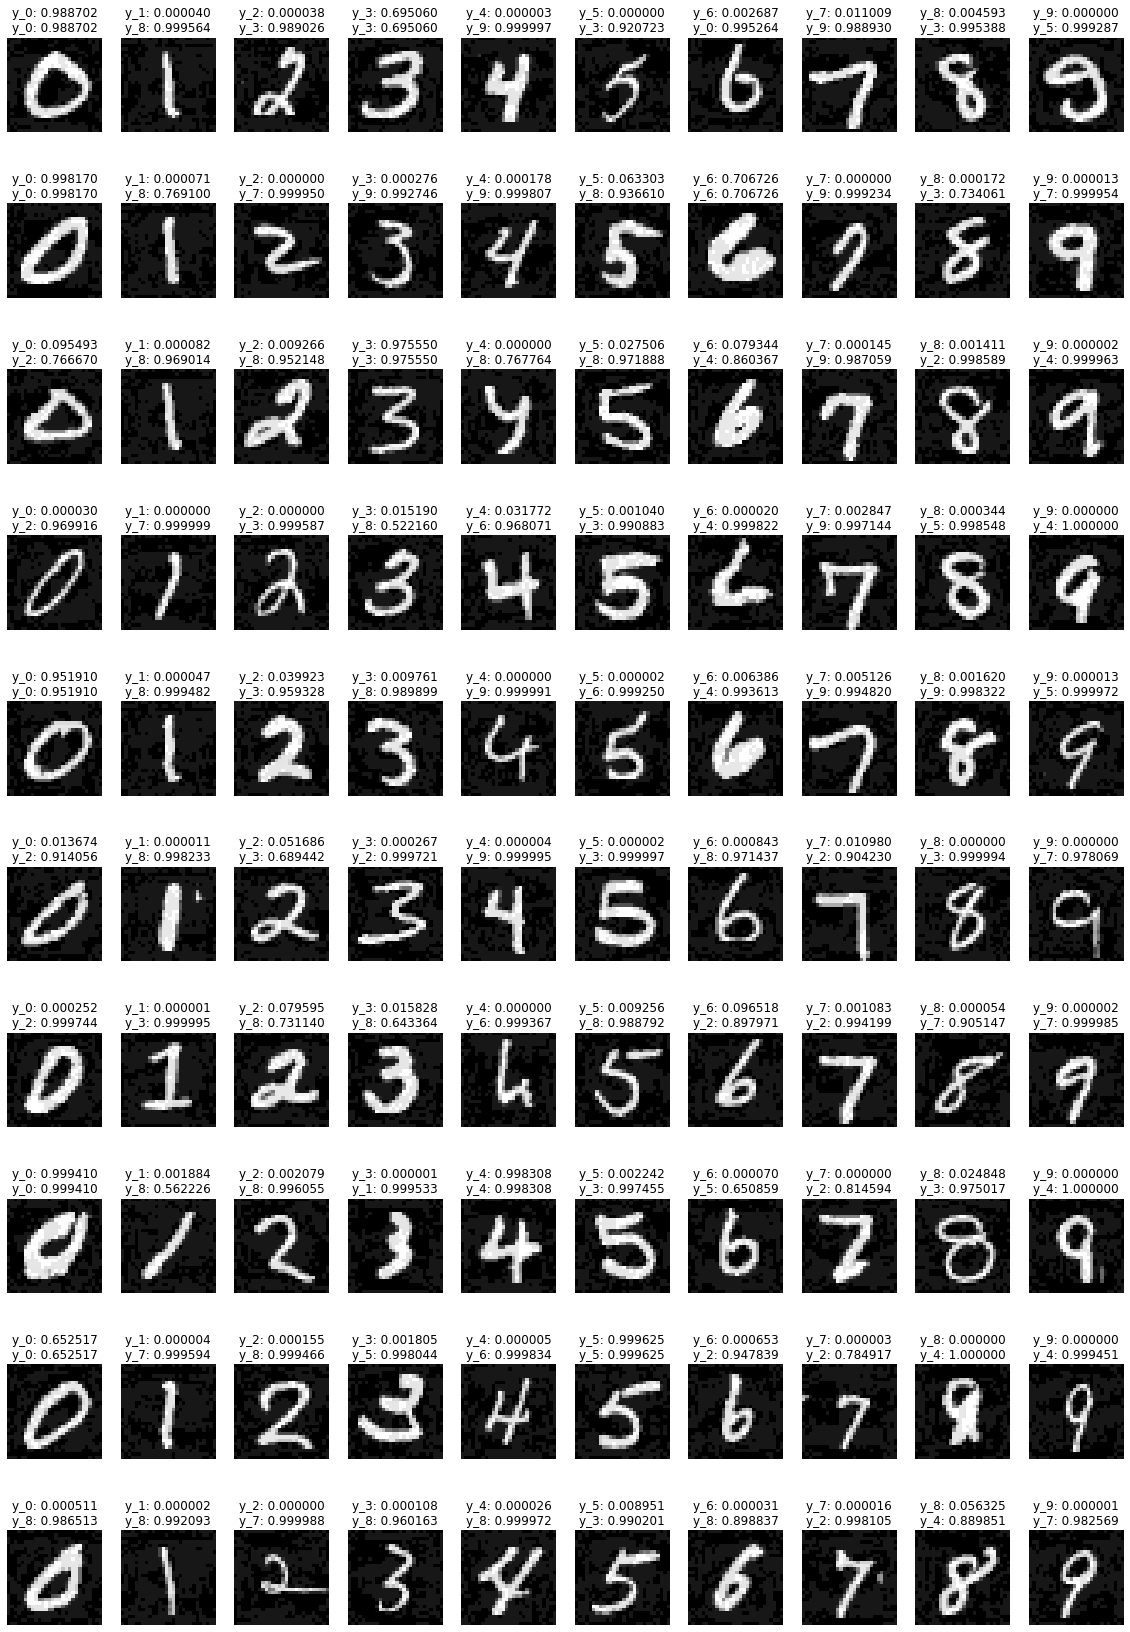

In [17]:
import math

plt.figure(figsize=(20,30))
number = t.numpy()

for i in range(100):
    plt.subplot(10,10,i+1)
    # Take a random digit which is corresponding to i
    list_index = random.choice(np.where(number == (i%10))[0])
    randomx = x[list_index] # The original digit data
    classes = i%10 # The class it belongs to
    
    # adv_x generateed corresponding to randomx
    adv_x = fgsm(net,x[list_index].unsqueeze(0),t[list_index].unsqueeze(0),0.05,False)
    prob_after_attack = net(adv_x)[0] # The output of the network on adv_x
    
    # Take the value for original class
    prob_for_original = math.exp(prob_after_attack[classes].item())
    
    # See which value is highest
    classes_after_attack = np.argmax(prob_after_attack.detach().numpy())
    
    # Compute its value
    prob_most = math.exp(prob_after_attack[classes_after_attack].item())
    
    # Format the output
    string  = "y_" + str(classes) + ": " + '{0:.6f}'.format(prob_for_original) + "\n"
    string2 = "y_" + str(classes_after_attack) + ": " + '{0:.6f}'.format(prob_most)
   
    draw(adv_x); plt.title(string + string2);

# C. Targetted

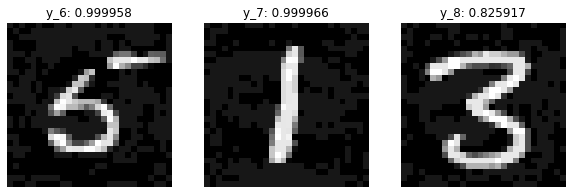

In [18]:
r1 = random.choice(np.where(number == (5))[0])
r2 = random.choice(np.where(number == (1))[0])
r3 = random.choice(np.where(number == (3))[0])

data1 = x[r1] # Pick some digit in class 5
data2 = x[r2] # Pick some digit in class 1
data3 = x[r3] # Pick some digit in class 3

class1 = t[r1] # class 5
class2 = t[r2] # class 1
class3 = t[r3] # class 3

# target to be 6
adv_x1 = fgsm(net,data1.unsqueeze(0),torch.tensor([6], dtype=torch.long),0.05,True)
# target to be 7
adv_x2 = fgsm(net,data2.unsqueeze(0),torch.tensor([7], dtype=torch.long),0.05,True)
# target to be 8
adv_x3 = fgsm(net,data3.unsqueeze(0),torch.tensor([8], dtype=torch.long),0.05,True)

# Find the result of network
prob_after_attack1 = net(adv_x1)[0]
prob_after_attack2 = net(adv_x2)[0]
prob_after_attack3 = net(adv_x3)[0]

# Find the probability
prob1 = math.exp(prob_after_attack1[6].item())
prob2 = math.exp(prob_after_attack2[7].item())
prob3 = math.exp(prob_after_attack3[8].item())

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
draw(adv_x1)
plt.title("y_" + str(6) + ": " + '{0:.6f}'.format(prob1));
plt.subplot(1,3,2)

draw(adv_x2)
plt.title("y_" + str(7) + ": " + '{0:.6f}'.format(prob2));
plt.subplot(1,3,3)
draw(adv_x3)
plt.title("y_" + str(8) + ": " + '{0:.6f}'.format(prob3));